In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST


In [45]:
BATCH_SIZE = 128
# Load Data
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform = transforms.Compose([transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])

trainset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainset, validset = torch.utils.data.random_split(trainset, 
                                [55000, 5000], 
                                generator=torch.Generator().manual_seed(42))
testset = FashionMNIST(root='./data', train=False, download=True, transform=transform)

trainLoader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validLoader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True)
testLoader = torch.utils.data.DataLoader(testset,batch_size=BATCH_SIZE, shuffle=True)

/home/leelin/anaconda3/envs/PyTorch/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630841592/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Task1

Train a CNN for image classification

对于 CNN 结构 作出如下几次调整

|                       问题                       |                              方案                               |                                 参数调整                                 | 效果                      |
| :----------------------------------------------: | :-------------------------------------------------------------: | :----------------------------------------------------------------------: | :------------------------ |
| 模型的 loss 在 trainSet 和 Validation 上相差较大 | 增加了两层 BatchNorm, 但是发现降低了整个模型的 acc， 后改为一层 |                      保留了两层卷积层中的 BatchNorm                      |
|             模型的过拟合问题仍然严重             |                         增加 Dropout 层                         | `nn.Dropout(0.2)`， 原为 `prob=0.5`, 发现训练收敛过慢，降低了 `prob=0.2` | 明显的降低了过拟合问题    |
|              模型的整体 acc 不够高               |                   提升了 Conv 的 channel 数量                   |              从 $1 \to 10 \to 28$ 改为了 $1 \to 14 \to 36$               | 从 $84\%$ 提升到了 $91\%$ |


In [102]:
# Model

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 14, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(14, 36, 3)
        self.bm1 = nn.BatchNorm2d(14)
        # self.bm2 = nn.BatchNorm2d(28)

        self.drop = nn.Dropout2d(0.2)
        self.fc1 = nn.Linear(36*5*5, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.bm1(x)
        x = self.drop(x) 
        x = self.pool(F.relu(self.conv2(x)))
        x = self.drop(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        res = self.fc3(x)
        return res


In [103]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
EPOCH = 20

cuda:0


In [104]:
# Train
net = CNN()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

training_losses, valid_losses = [], []
for epoch in range(EPOCH): 
    running_loss = 0.0
    net.train()
    for i, data in enumerate(trainLoader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()        
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    # Validation
    valid_loss = 0.0
    net.eval()
    for i, data in enumerate(validLoader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        valid_pred = net(inputs)
        loss = criterion(valid_pred, labels)

        valid_loss += loss.item() * inputs.size(0)
        
    running_loss /= len(trainLoader)
    valid_loss /= len(validLoader)
    print("Epoch {:3}\t Training Loss: {:.3f} \t Validataion Loss: {:.3f}".format(epoch+1, running_loss, valid_loss))
    training_losses.append(running_loss)
    valid_losses.append(valid_loss)
    
        
print("Over")

# Save model
torch.save(net.state_dict(), './model/cnn.pth')


Epoch   1	 Training Loss: 92.053 	 Validataion Loss: 55.078
Epoch   2	 Training Loss: 53.758 	 Validataion Loss: 47.306
Epoch   3	 Training Loss: 46.525 	 Validataion Loss: 40.668
Epoch   4	 Training Loss: 42.468 	 Validataion Loss: 39.281
Epoch   5	 Training Loss: 39.406 	 Validataion Loss: 36.863
Epoch   6	 Training Loss: 37.732 	 Validataion Loss: 37.676
Epoch   7	 Training Loss: 35.786 	 Validataion Loss: 34.646
Epoch   8	 Training Loss: 34.147 	 Validataion Loss: 33.539
Epoch   9	 Training Loss: 33.268 	 Validataion Loss: 34.657
Epoch  10	 Training Loss: 31.873 	 Validataion Loss: 31.825
Epoch  11	 Training Loss: 30.933 	 Validataion Loss: 31.833
Epoch  12	 Training Loss: 29.934 	 Validataion Loss: 31.141
Epoch  13	 Training Loss: 29.181 	 Validataion Loss: 30.193
Epoch  14	 Training Loss: 28.300 	 Validataion Loss: 30.657
Epoch  15	 Training Loss: 27.658 	 Validataion Loss: 29.665
Epoch  16	 Training Loss: 26.689 	 Validataion Loss: 31.124
Epoch  17	 Training Loss: 26.283 	 Valid

In [105]:
classes = [
	"T-shirt/top"
	,"Trouser"
	,"Pullover"
	,"Dress"
	,"Coat"
	,"Sandal"
	,"Shirt"
	,"Sneaker"
	,"Bag"
	,"Ankle boot"
]
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testLoader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)

        _, predictions = torch.max(outputs, 1)

        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

total_correct = sum([x[1] for x in correct_pred.items()])
total_pred = sum([x[1] for x in total_pred.items()])
print('Total ACC: ', total_correct / total_pred)

Accuracy for class: T-shirt/top is 87.3 %
Accuracy for class: Trouser is 98.5 %
Accuracy for class: Pullover is 88.2 %
Accuracy for class: Dress is 91.4 %
Accuracy for class: Coat  is 81.7 %
Accuracy for class: Sandal is 98.1 %
Accuracy for class: Shirt is 73.5 %
Accuracy for class: Sneaker is 95.6 %
Accuracy for class: Bag   is 98.7 %
Accuracy for class: Ankle boot is 96.7 %
Total ACC:  0.9097


#### 进一步提升

通过输出不同 class 的 acc， 可以看到模型在 T-shirt 和 shirt 分类上有混淆的问题，在我个人更改模型参数的过程中，出现这两个类总是此消彼长，不会同时升高

后期希望可以通过一些 Attention 的方法来改善


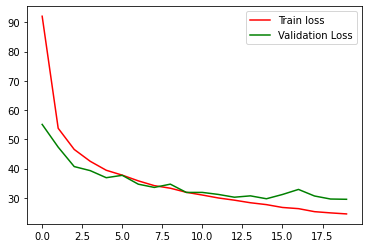

In [106]:

import matplotlib.pyplot as plt

plt.plot(training_losses, 'r', label='Train loss')
plt.plot(valid_losses, 'g', label='Validation Loss')

plt.legend()
plt.show()

|                     描述                     |             图片              |  acc   |
| :------------------------------------------: | :---------------------------: | :----: |
| 无 BatchNorm， Dropout， 但是 channel 数较大 |   ![img1](imgs/output1.png)   | 90.1 % |
| 无 BatchNorm， Dropout， 但是 channel 数较小 | ![img2](imgs/output_9035.png) | 90.3 % |
|  有 BatchNorm， Dropout， 且 channel 数较大  |   ![img3](imgs/output.png)    | 90.9 % |


## Task 2

Build saliency map for all classes


In [79]:
############################################################################
# Copy and modify from: 
# https://notebook.community/ALEXKIRNAS/DataScience/CS231n/assignment3/NetworkVisualization-PyTorch
############################################################################ 
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Wrap the input tensors in Variables
    X.requires_grad_()
    saliency = None
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores, and then compute the gradients with a backward pass.               #
    ##############################################################################
    
    scores = model(X)
    labels_scores = scores.gather(1, y.view(-1, 1)).squeeze()
    
    loss = -torch.sum(torch.log(labels_scores))
    loss.backward()
    
    images_grads = X.grad.data
    abs_images_grads = images_grads.abs()
    saliency, _ = abs_images_grads.max(dim=1)

    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

def show_saliency_maps(X, y, model):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([x for x in X], dim=0)
    X_tensor = X_tensor.unsqueeze(1)
    # X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)

    print(X_tensor.size(), y_tensor.size())

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()

    N = len(X)
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i].squeeze())
        plt.axis('off')
        plt.title(classes[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 3)
    plt.show()

torch.Size([128, 1, 28, 28])
dict_keys([8, 5, 9, 3, 2, 0, 7, 4, 6, 1])
torch.Size([10, 1, 28, 28]) torch.Size([10])


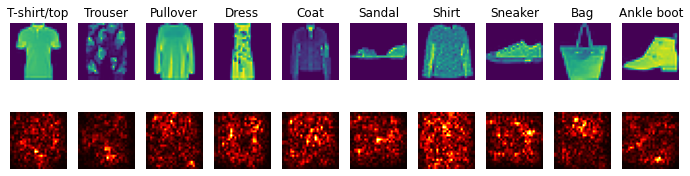

In [80]:
tmp = {}
for datas, labels in trainLoader:
    print(datas.size())
    for idx, label in enumerate(labels, 0):
        if tmp.get(label, None) is None:
            tmp[label.item()] = datas[idx]
    
    if all(cls in tmp.keys() for cls in range(10)):
        break
        
print(tmp.keys())
X = []; y = []
for cls in range(10):
    X.append(tmp[cls])
    y.append(cls)


model = CNN()
model.load_state_dict(torch.load('model/cnn.pth'))
model.eval()
show_saliency_maps(X, y, model)

## Task 3

Try to get input to maximize the filters in CNN

$$
    \argmax_{x} S(x) + \text{Norm}(x)
$$


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([14, 1, 5, 5])


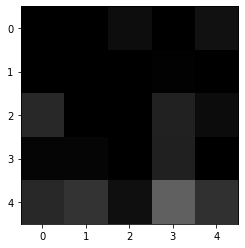

In [50]:
# Demo code for visualize filer
import torchvision
conv1_kernels = model.conv1.weight.detach().clone()
#check size for sanity check
print(conv1_kernels.size())
# normalize to (0,1) range so that matplotlib
# can plot them
conv1_kernels.norm()
conv1_kernels = conv1_kernels[0]

filter_img = torchvision.utils.make_grid(conv1_kernels, nrow = 12)
# change ordering since matplotlib requires images to 
# be (H, W, C)
plt.imshow(filter_img.permute(1, 2, 0))

In [77]:
class MaxFilter(nn.Module):
    """
        As score function:
            output is the max of all pixels
    """
    def __init__(self, target_filter):
        super().__init__()
        out_channels = target_filters.size(0)
        self.conv = nn.Conv2d(1, out_channels, 5, stride=1)
        with torch.no_grad():
            self.conv.weight.data = target_filters
        
    def forward(self, x):
        x = self.conv(x)
        res = x.view(x.size(0), -1)
        res = torch.max(res) # change to sum/mean/max to apply different score function
        return res

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 1, 5, 5])
torch.Size([3, 1, 5, 5])


Text(0.5, 1.0, 'Max activation')

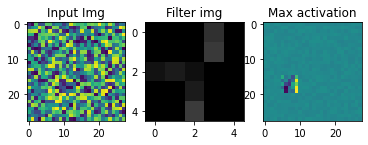

In [78]:
import matplotlib.pyplot as plt



# Initialize a input randomly Or sample from trainLoader
x = torch.rand(1, 1, 28, 28)
# x, _ = next(iter(trainLoader)) 
# x = x[0].unsqueeze(0)
# print(x.size())
x.requires_grad_(True)

plt.subplot(1, 3, 1)
plt.imshow(x.squeeze(0).permute(1, 2, 0).detach().numpy())
plt.title('Input Img')


# Load filter from saved model to initialize a conv layer
origin_model = CNN()
origin_model.load_state_dict(torch.load('model/cnn.pth'))
origin_model.eval()
target_filters = origin_model.conv1.weight[10:13].detach().clone()
filter_img = torchvision.utils.make_grid(target_filters[0], nrow = 12)
# change ordering since matplotlib requires images to 
# be (H, W, C)
plt.subplot(1, 3, 2)
plt.imshow(filter_img.permute(1, 2, 0))
plt.title('Filter img')

scrModel = MaxFilter(target_filters) # treat as score function S(I)
x_copy = x.clone()
lr = 0.01
for i in range(100):
    filter_scr = scrModel(x)
    loss = filter_scr + torch.norm(x, p=2) # change p to apply l1 or l2 norm
    loss.backward()

    x_copy += -lr * x.grad.data # leaf tensor can't use in-place operation

plt.subplot(1, 3, 3)
plt.imshow(x_copy.squeeze(0).permute(1, 2, 0).detach().numpy())
plt.title('Max activation')
